In [35]:

import os
import cv2 
from PIL import Image
from tqdm import tqdm
import numpy as np
import shutil
import glob
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import tensorflow as tf


In [10]:
seed = 42
np.random.seed = seed

In [11]:
#define main images path
path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'

In [12]:
#define function to  get image number 
def num (image) :  
    val = 0

    for i in range(len(image)) :
        if image[i] == '(' :
            while True :
                i += 1
                if image[i] == ')' :
                    break
                val = (val*10) + int(image[i])
            break
    
    return val

In [13]:
def getCountOfImage():
    classes = [ 'benign', 'normal','malignant']
    label = 0
    labels =[]
    bengin=0
    malignant=0
    normal=0
    for cname in  os.listdir(path):
       for filename in sorted (os.listdir(os.path.join(path,cname))):
           if  not '_mask' in filename :
               if 'benign' in filename :
                bengin+=1
               elif 'malignant' in filename:
                 malignant +=1  
               elif 'normal' in filename:
                 normal +=1  
           
    return int(bengin), int(malignant),int(normal)   

In [14]:
#get count of images
bengin , malignant,normal =getCountOfImage()

In [15]:
cv2.__version__

'4.5.4'

In [16]:
size_x ,size_y =128,128

In [17]:
#create empty array of zeros to store image inside it
x_bengin    = np.zeros((bengin,size_x,size_y,1))
y_bengin     = np.zeros((bengin,size_x,size_y,1))
x_malignant = np.zeros((malignant,size_x,size_y,1))
y_malignant = np.zeros((malignant,size_x,size_y,1))
x_normal   = np.zeros((normal,size_x,size_y,1))
y_normal    = np.zeros((normal,size_x,size_y,1))

In [36]:
#start load image
                #2        #1          #0
classes = [ 'benign', 'normal','malignant']
label = 0
labels =[] #for classification part
images = [] #for classification part
for cname in  os.listdir(path):
    for filename in sorted (os.listdir(os.path.join(path,cname))):
        imagePath = path +cname+'/'+filename
        image = cv2.imread(imagePath,cv2.IMREAD_GRAYSCALE)
        if filename[-5] == ')' :
            image = cv2.resize(image,(size_x,size_y))
            image =np.array(image)
            images.append(image)
            image =np.expand_dims(image,axis=-1)
            #load x_bengin images
            if filename[0]=='b':
                x_bengin[num(filename)-1]+= np.array(image)
                labels.append(int(2))
            if filename[0] == 'n' : 
                x_normal[num(filename)-1]+= np.array(image)
                labels.append(int(1))
            if filename[0] == 'm' :
                x_malignant[num(filename)-1]+= np.array(image)
                labels.append(int(0))
        else:
            image = cv2.resize(image,(size_x,size_y))
            image =np.array(image)
            image =np.expand_dims(image,axis=-1)
            if filename[0]=='b':
                y_bengin[num(filename)-1]+= np.array(image)
            if filename[0] == 'n' : 
                y_normal[num(filename)-1]+= np.array(image)
            if filename[0] == 'm' :
                y_malignant[num(filename)-1]+= np.array(image)

****

#   ****benign Images****

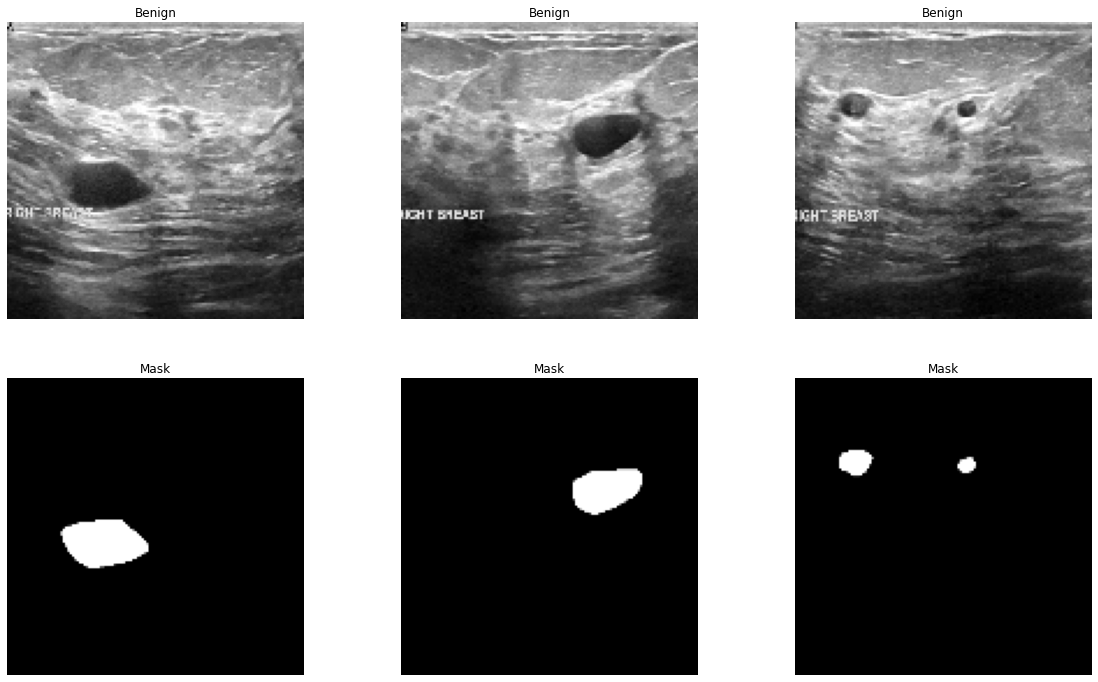

In [37]:
plt.figure(figsize = (20,12))

for i in range(3) :
    plt.subplot(2,3,i+1)
    plt.imshow(np.squeeze(x_bengin[i+1]), 'gray')
    plt.title('Benign')
    plt.axis('off')

for i in range(3) :
    plt.subplot(2,3,i+4)
    plt.imshow(np.squeeze(y_bengin[i+1]), 'gray')
    plt.title('Mask')
    plt.axis('off')
plt.show()




# malignant Images

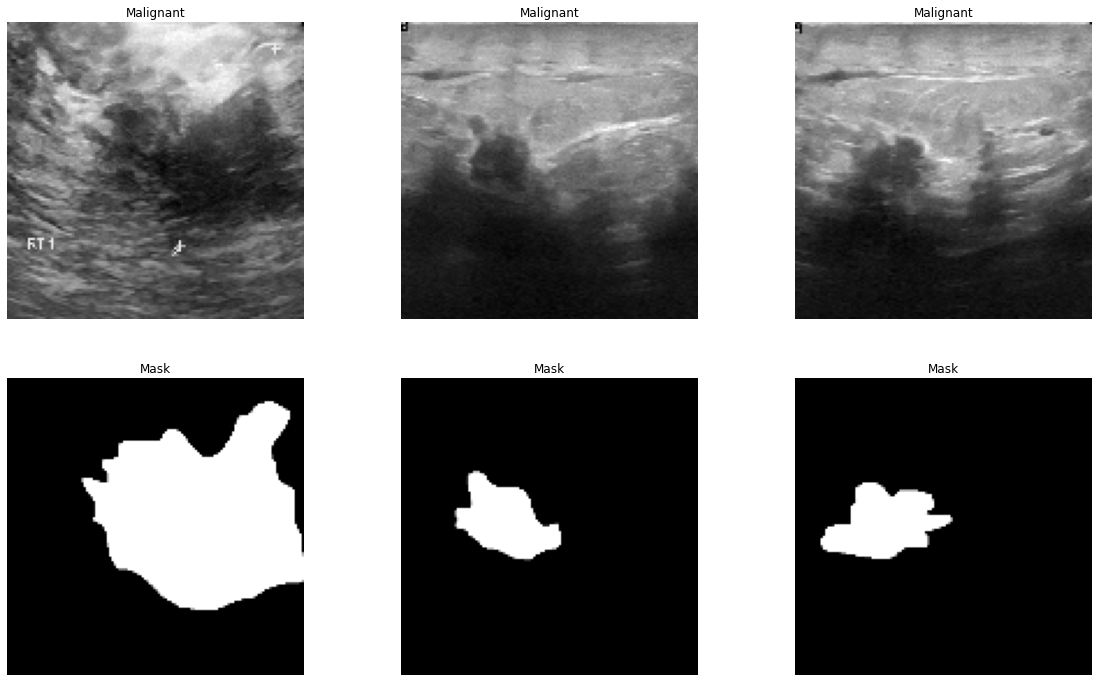

In [38]:
plt.figure(figsize = (20,12))

for i in range(3) :
    plt.subplot(2,3,i+1)
    plt.imshow(np.squeeze(x_malignant[i+1]), 'gray')
    plt.title('Malignant')
    plt.axis('off')

for i in range(3) :
    plt.subplot(2,3,i+4)
    plt.imshow(np.squeeze(y_malignant[i+1]), 'gray')
    plt.title('Mask')
    plt.axis('off')
plt.show()




# normal Images

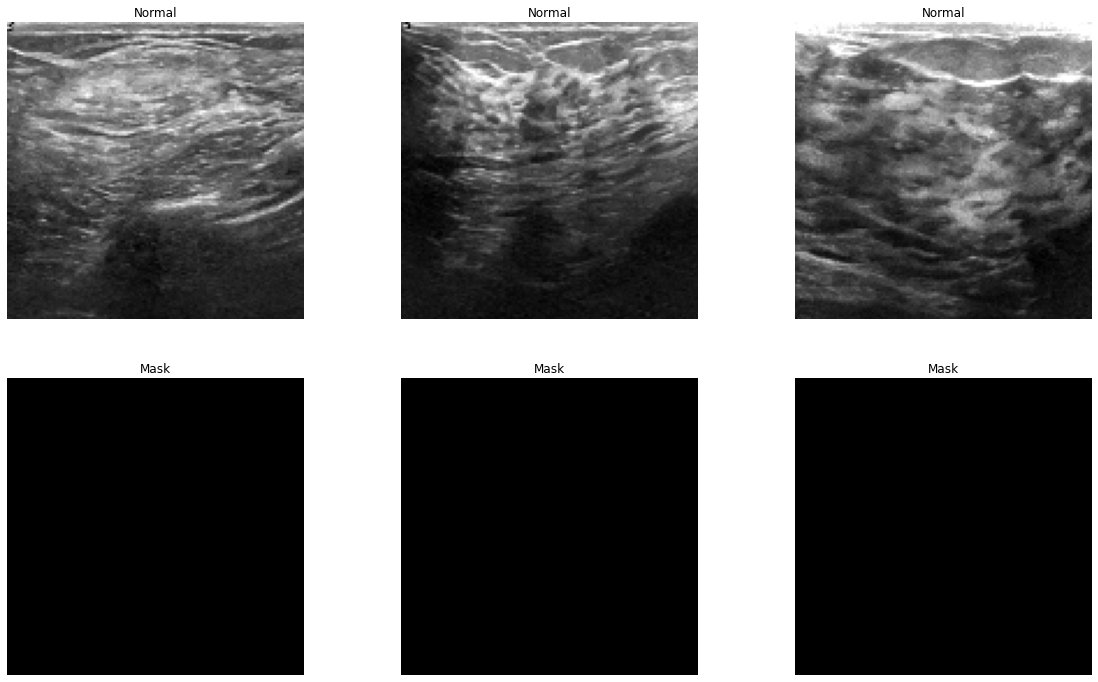

In [39]:
plt.figure(figsize = (20,12))

for i in range(3) :
    plt.subplot(2,3,i+1)
    plt.imshow(np.squeeze(x_normal[i+1]), 'gray')
    plt.title('Normal')
    plt.axis('off')

for i in range(3) :
    plt.subplot(2,3,i+4)
    plt.imshow(np.squeeze(y_normal[i+1]), 'gray')
    plt.title('Mask')
    plt.axis('off')
plt.show()




In [40]:
#collect all images 
images_seg = (np.concatenate((x_bengin, x_normal, x_malignant), axis = 0))/255
masks = (np.concatenate((y_bengin, y_normal, y_malignant), axis = 0))/255
print(images_seg.shape)
print(masks.shape)

(780, 128, 128, 1)
(780, 128, 128, 1)


# ploting Random Images

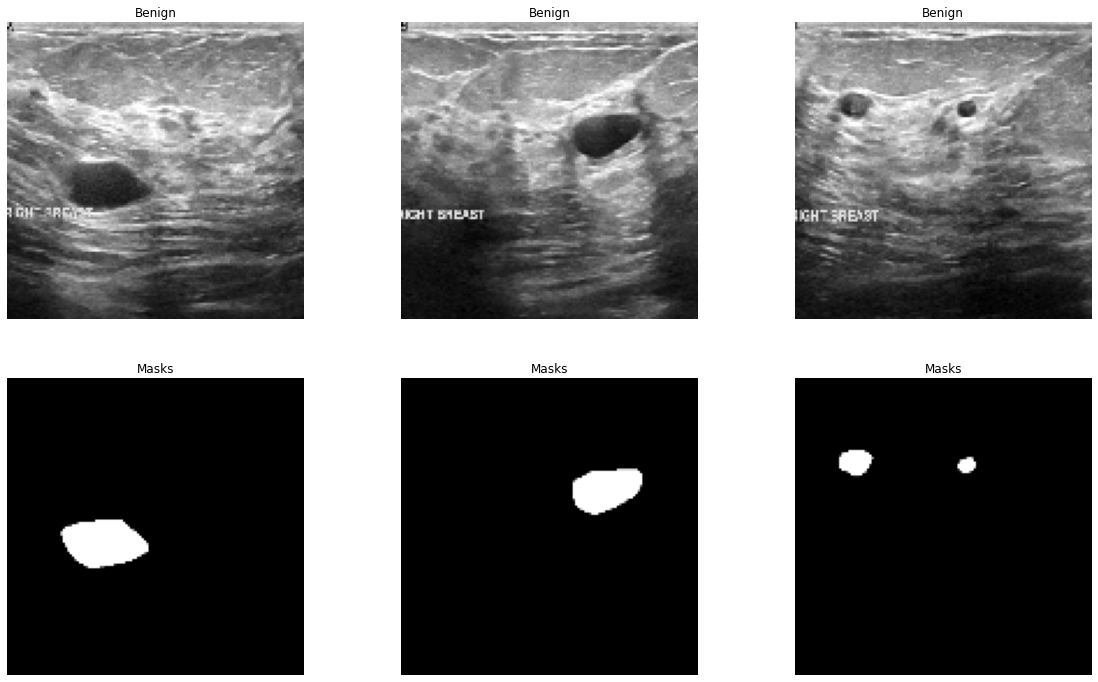

In [41]:
plt.figure(figsize = (20,12))

for i in range(3) :
    plt.subplot(2,3,i+1)
    plt.imshow(np.squeeze(images_seg[i+1]), 'gray')
    plt.title('Benign')
    plt.axis('off')

for i in range(3) :
    plt.subplot(2,3,i+4)
    plt.imshow(np.squeeze(masks[i+1]), 'gray')
    plt.title('Masks')
    plt.axis('off')
plt.show()




In [34]:
image_height  = 128
image_width   = 128
image_channel = 1


In [42]:
               #Lib

import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold
import numpy as np
import sys
import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import cv2
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,AveragePooling2D,BatchNormalization,LayerNormalization
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.layers import Flatten,Dropout,SpatialDropout2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam                                

In [43]:
# loading the dataset
path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'
dir_list = [os.path.join(path,i) for i in os.listdir(path)]
size_dict = {}
for i,value in enumerate(dir_list):
    size_dict[os.listdir(path)[i]] = len(os.listdir(value))
size_dict 

{'benign': 891, 'normal': 266, 'malignant': 421}

In [44]:
import re
def clean(name):
    name = re.sub('[benign ().p]','',str(name))
    return name

In [45]:
# removing mask benign images

df = pd.DataFrame(os.listdir(dir_list[0]))
# df = df.apply(str,axis=1)
df = df[0].apply(clean)
# print(df.info())
df = df[~df.str.contains('mask',regex =False)]
df = df.apply(int)
df_list = list(df)
type(df_list)
df_list.sort()
print(len(df_list))

437


In [46]:
img_size = 128
img_channel = 3
# X_b --> benign,  Xm_b --> Mask benign
# X_n --> normal, Xm_n ---> Mask normal
# X_m --> malignant, Xm_m --> Mask malignant
X_b , Xm_b , y_b = np.zeros((437,img_size,img_size,img_channel)) , np.zeros((437,img_size,img_size,img_channel)) , np.full(437,'benign') 
X_n , Xm_n , y_n = np.zeros((133,img_size,img_size,img_channel)) , np.zeros((133,img_size,img_size,img_channel)) , np.full(133,'normal') 
X_m , Xm_m , y_m = np.zeros((210,img_size,img_size,img_channel)) , np.zeros((210,img_size,img_size,img_channel)) , np.full(210,'malignant')

In [47]:
img1_path = os.path.join(os.path.join(path,'benign'),os.listdir(os.path.join(path,'benign'))[1])

pil_img = load_img(img1_path,color_mode = 'rgb',target_size=(img_size,img_size))
img = img_to_array(pil_img)
img_shape = img.shape
print(img_shape)

def img_num(filename):
    
    val = 0
    
    for i in range(len(filename)) :
        if filename[i] == '(' :
            while True :
                i += 1
                if filename[i] == ')' :
                    break
                val = (val*10) + int(filename[i])
            break
    
    return val

for tumor_path in dir_list :
    for image in os.listdir(tumor_path) :
        p = os.path.join(tumor_path, image)
        pil_img = load_img(p,color_mode = 'rgb',target_size=(img_size,img_size))         # read image as  grayscale ans resize it
        
        if image[-5] == ')' :                                   #if real image 
            
            if image[0] == 'b' :
                X_b[img_num(image)-1]+= img_to_array(pil_img)  # If image is real add it
            if image[0] == 'n' :                               # to X as benign , normal
                X_n[img_num(image)-1]+= img_to_array(pil_img)  # or malignant.
            if image[0] == 'm' :
                X_m[img_num(image)-1]+= img_to_array(pil_img)
        else :                                                 #else masked image
            
            if image[0] == 'b' :
                Xm_b[img_num(image)-1]+= img_to_array(pil_img)  # Similarly add the target
            if image[0] == 'n' :                               # mask to y.
                Xm_n[img_num(image)-1]+= img_to_array(pil_img)
            if image[0] == 'm' :
                Xm_m[img_num(image)-1]+= img_to_array(pil_img)

(128, 128, 3)


In [71]:
X = np.concatenate((X_b, X_n, X_m), axis = 0)
Xm = np.concatenate((Xm_b, Xm_n, Xm_m), axis = 0)
y = np.concatenate((y_b, y_n, y_m), axis = 0)

print(X.shape)
print(Xm.shape)
print(y.shape)
X /= 255.0
Xm /= 255.0

print(X.max())
print(Xm.min())

(780, 128, 128, 3)
(780, 128, 128, 3)
(780,)
1.0
0.0


In [72]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

encoder  = OneHotEncoder()
# y = y.toarray()
y=encoder.fit_transform(y.reshape(y.shape[0],1))

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.15,shuffle=True,random_state=42)
Xm_train,Xm_test,ym_train,ym_test = train_test_split(Xm,y,test_size = 0.15,shuffle=True,random_state=42,stratify=y.toarray())

class_list = encoder.categories_
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(663, 128, 128, 3) (117, 128, 128, 3)
(663, 3) (117, 3)


In [73]:
from sklearn.metrics import f1_score,roc_auc_score,cohen_kappa_score
def evaluation(model,X_train,y_train,X_val,y_val,X_test,y_test,history):
    train_loss , train_acc = model.evaluate(X_train,y_train.toarray())
    val_loss, val_acc = model.evaluate(X_val,y_val.toarray())
    test_loss_value , test_accuracy = model.evaluate(X_test, y_test.toarray())
    y_pred = model.predict(X_test)
    y_pred_label = np.argmax(y_pred,axis=1)
    y_true_label = np.argmax(y_test,axis=1)
    print("Train accuracy = "+str(train_acc))
    print("Validation accuracy = "+str(val_acc))
    print('Test accuracy = ' + str(test_accuracy))


In [74]:
# Data visualing in plots

import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (10,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()

In [75]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


def fit_evaluate(model,X_train,y_train,X_test,y_test,bs,Epochs,patience): #bs-->batch_size
    es = EarlyStopping(monitor='val_loss', mode='min', patience=patience,restore_best_weights=True, verbose=1)
    X1_train,X_val,y1_train,y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=42,stratify = y_train.toarray())
    history = model.fit(X1_train,y1_train.toarray(),batch_size = bs,epochs=Epochs,validation_data = (X_val,y_val.toarray()), callbacks=[es])
    evaluation(model,X1_train,y1_train,X_val,y_val,X_test,y_test,history)
    Train_Val_Plot(history.history['acc'],history.history['val_acc'],history.history['loss'],history.history['val_loss'])

In [76]:
base_model =tf.keras.applications.DenseNet201(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=img_shape,
    pooling=None,
    #classifier_activation="softmax",
)



for layer in base_model.layers:
    layer.trainable = False

*This code is typically used when we want to use the pre-trained DenseNet201 model as a feature extractor and add our own custom classification layers on top.  By freezing the base model layers,  This means that during training, these layers will not be updated or modified. We freeze the weights of these layers because they have already been trained on a large dataset and contain valuable learned features. we ensurethat only the newly added layers are trained on our specific dataset, while the pre-trained features are preserved.*

In [77]:
def DenseNet201():

    model = Sequential()
    model.add(base_model)
    
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3,activation='softmax'))
    
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc']) 
    
    return model

The softmax activation assigns probabilities to each class, indicating the model's prediction confidence for each class.

This architecture adds additional layers on top of the pre-trained DenseNet201 to further refine the learned representations and adapt them to the specific classification task at hand

In [78]:
model = DenseNet201()
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 4, 4, 1920)        18321984  
_________________________________________________________________
flatten_2 (Flatten)          (None, 30720)             0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 30720)             122880    
_________________________________________________________________
dense_10 (Dense)             (None, 512)               15729152  
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)              

"batch_normalization (BatchNormalization)": This layer applies batch normalization to the flattened input. It helps in normalizing the activations of the previous layer and improving the stability and speed of training.

The softmax activation is particularly useful in multi-class classification tasks because it provides a probability distribution that indicates the model's confidence or belief in each class. The class with the highest probability can be considered as the predicted class by the model.

The "Total params" indicates the total number of parameters in the model, which is 34,346,691. The "Trainable params" represents the number of trainable parameters in the model, which is 15,963,267. The "Non-trainable params" indicates the number of non-trainable parameters inherited from the pre-trained DenseNet201 base model, which is 18,383,424.

16: The batch size, which specifies how many samples are processed in each training iteration.
30: The number of epochs, which determines how many times the model will iterate over the entire training dataset.
4: The patience value for early stopping, which indicates the number of epochs to wait before stopping training if the validation loss does not improve

Epoch 1/30
38/38 [==============================] - 30s 231ms/step - loss: 4.4772 - acc: 0.4681 - val_loss: 2.0022 - val_acc: 0.5672
Epoch 2/30
38/38 [==============================] - 2s 45ms/step - loss: 3.5743 - acc: 0.5185 - val_loss: 0.6774 - val_acc: 0.7612
Epoch 3/30
38/38 [==============================] - 2s 47ms/step - loss: 3.0054 - acc: 0.5369 - val_loss: 0.8823 - val_acc: 0.7313
Epoch 4/30
38/38 [==============================] - 2s 45ms/step - loss: 2.4903 - acc: 0.5067 - val_loss: 0.8968 - val_acc: 0.6269
Epoch 5/30
38/38 [==============================] - 2s 47ms/step - loss: 1.9427 - acc: 0.5336 - val_loss: 0.8735 - val_acc: 0.5672
Epoch 6/30
38/38 [==============================] - 2s 45ms/step - loss: 1.9968 - acc: 0.5302 - val_loss: 0.8435 - val_acc: 0.5672
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping
4/4 [==============================] - 2s 640ms/step - loss: 0.8252 - acc: 0.6667
Train accuracy = 0.6744966506958008
Validation

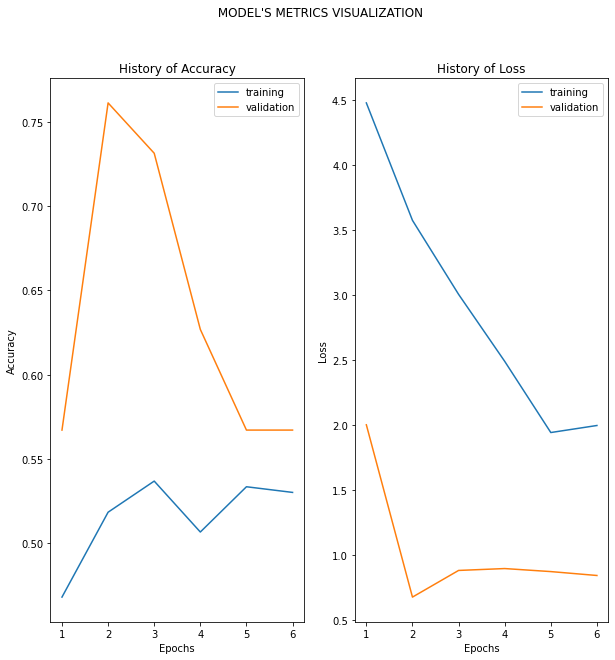

In [79]:
# densenet201 
fit_evaluate(model,X_train,y_train,X_test,y_test,16,30,4)

By calling fit_evaluate, you are training the DenseNet201 model on the training data, evaluating its performance on the validation and testing data, and visualizing the training progress.

In [80]:
y_pred  = model.predict(X_test)
y_pred

array([[9.89741206e-01, 1.00208279e-02, 2.38016655e-04],
       [3.32887769e-01, 5.29514015e-01, 1.37598127e-01],
       [3.95750523e-01, 2.37343505e-01, 3.66905957e-01],
       [3.42901498e-01, 3.65593910e-01, 2.91504622e-01],
       [3.91191453e-01, 2.67670155e-01, 3.41138333e-01],
       [3.98765504e-01, 2.20201552e-01, 3.81032944e-01],
       [6.00976825e-01, 1.80719659e-01, 2.18303546e-01],
       [4.33787555e-01, 2.63746172e-01, 3.02466273e-01],
       [2.83743680e-01, 5.02074420e-01, 2.14181960e-01],
       [3.85666519e-01, 6.11650527e-01, 2.68288516e-03],
       [9.50772762e-01, 3.39699872e-02, 1.52573008e-02],
       [1.66199580e-02, 9.83362675e-01, 1.73705630e-05],
       [3.70738357e-01, 3.85084778e-01, 2.44176894e-01],
       [4.26235795e-01, 3.75241905e-01, 1.98522240e-01],
       [2.55300820e-01, 7.25161076e-01, 1.95381343e-02],
       [9.91751611e-01, 3.27392109e-03, 4.97443089e-03],
       [5.66189289e-01, 1.67197555e-01, 2.66613185e-01],
       [9.99999166e-01, 7.80256

In [ ]:
# training on Mask data
model1 = DenseNet201()
model1.summary()
fit_evaluate(model1,Xm_train,ym_train,Xm_test,ym_test,16,30,4)

In [37]:
y_pred  = model1.predict(X_test)
y_pred

array([[1.00000000e+00, 1.42304324e-09, 3.86439292e-19],
       [5.20569720e-15, 1.00000000e+00, 1.85771782e-26],
       [9.99296665e-01, 6.96853094e-04, 6.38275924e-06],
       [3.07233888e-04, 9.99692798e-01, 9.35591427e-09],
       [7.86570126e-07, 9.99999166e-01, 9.51785647e-14],
       [9.99999404e-01, 5.80680762e-07, 1.51830049e-09],
       [8.35064639e-05, 9.99916434e-01, 8.41684632e-13],
       [9.86175478e-01, 1.38076451e-02, 1.68078586e-05],
       [1.00000000e+00, 7.48593326e-18, 4.22237337e-26],
       [1.00000000e+00, 5.30828723e-12, 5.87802853e-22],
       [1.00000000e+00, 2.97827025e-08, 9.39764314e-16],
       [1.00000000e+00, 1.30198865e-23, 9.73271707e-31],
       [9.62031947e-08, 9.99999881e-01, 6.85686850e-15],
       [9.84324217e-01, 1.56685878e-02, 7.13169175e-06],
       [1.04232226e-03, 9.98957515e-01, 1.26161396e-07],
       [1.00000000e+00, 1.46273016e-33, 0.00000000e+00],
       [1.00000000e+00, 1.88023347e-10, 5.97173093e-15],
       [2.56822254e-12, 1.00000

In [38]:
#  

# Data visualization

In [81]:
import os
import cv2 
from PIL import Image
from tqdm import tqdm
import numpy as np
import shutil
import glob
from matplotlib import pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras

In [82]:
seed = 42
np.random.seed = seed

In [83]:
#define main images path
path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'

In [84]:
#define function to  get image number 
def num (image) :  
    val = 0

    for i in range(len(image)) :
        if image[i] == '(' :
            while True :
                i += 1
                if image[i] == ')' :
                    break
                val = (val*10) + int(image[i])
            break
    
    return val

In [85]:
def getCountOfImage():
    classes = [ 'benign', 'normal','malignant']
    label = 0
    labels =[]
    bengin=0
    malignant=0
    normal=0
    for cname in  os.listdir(path):
       for filename in sorted (os.listdir(os.path.join(path,cname))):
           if  not '_mask' in filename :
               if 'benign' in filename :
                bengin+=1
               elif 'malignant' in filename:
                 malignant +=1  
               elif 'normal' in filename:
                 normal +=1  
           
    return int(bengin), int(normal),int(malignant) 

In [86]:
#get count of images
bengin ,normal,malignant =getCountOfImage()

In [87]:
size_x ,size_y =128,128

In [88]:
#create empty array of zeros to store image inside it
x_bengin    = np.zeros((bengin,size_x,size_y,1))
y_bengin     = np.zeros((bengin,size_x,size_y,1))
x_malignant = np.zeros((malignant,size_x,size_y,1))
y_malignant = np.zeros((malignant,size_x,size_y,1))
x_normal   = np.zeros((normal,size_x,size_y,1))
y_normal    = np.zeros((normal,size_x,size_y,1))

In [89]:
#start load image
                #2        #1          #0
classes = [ 'benign', 'normal','malignant']
label = 0
labels =[] #for classification part
images = [] #for classification part
for cname in  os.listdir(path):
    for filename in sorted (os.listdir(os.path.join(path,cname))):
        imagePath = path +cname+'/'+filename
        image = cv2.imread(imagePath,cv2.IMREAD_GRAYSCALE)
        if filename[-5] == ')' :
            image = cv2.resize(image,(size_x,size_y))
            image =np.array(image)
            images.append(image)
            image =np.expand_dims(image,axis=-1)
            #load x_bengin images
            if filename[0]=='b':
                x_bengin[num(filename)-1]+= np.array(image)
                labels.append(int(2))
            if filename[0] == 'n' : 
                x_normal[num(filename)-1]+= np.array(image)
                labels.append(int(1))
            if filename[0] == 'm' :
                x_malignant[num(filename)-1]+= np.array(image)
                labels.append(int(0))
        else:
            image = cv2.resize(image,(size_x,size_y))
            image =np.array(image)
            image =np.expand_dims(image,axis=-1)
            if filename[0]=='b':
                y_bengin[num(filename)-1]+= np.array(image)
            if filename[0] == 'n' : 
                y_normal[num(filename)-1]+= np.array(image)
            if filename[0] == 'm' :
                y_malignant[num(filename)-1]+= np.array(image)

# bengin Images

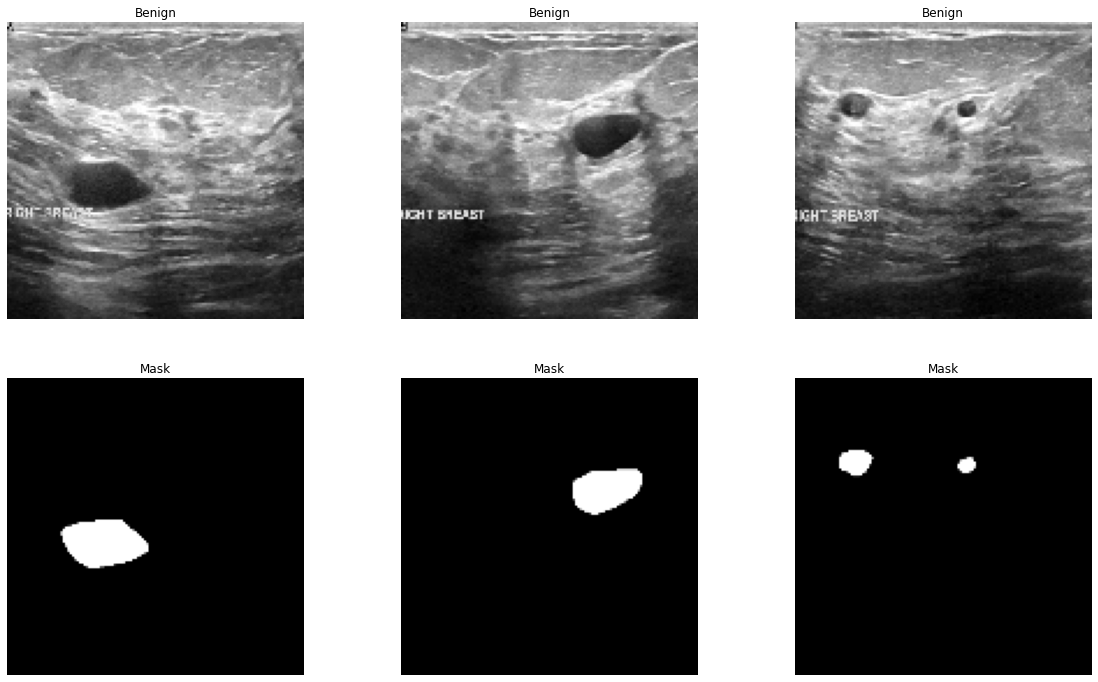

In [90]:
plt.figure(figsize = (20,12))

for i in range(3) :
    plt.subplot(2,3,i+1)
    plt.imshow(np.squeeze(x_bengin[i+1]), 'gray')
    plt.title('Benign')
    plt.axis('off')

for i in range(3) :
    plt.subplot(2,3,i+4)
    plt.imshow(np.squeeze(y_bengin[i+1]), 'gray')
    plt.title('Mask')
    plt.axis('off')
plt.show()

# malignant Images

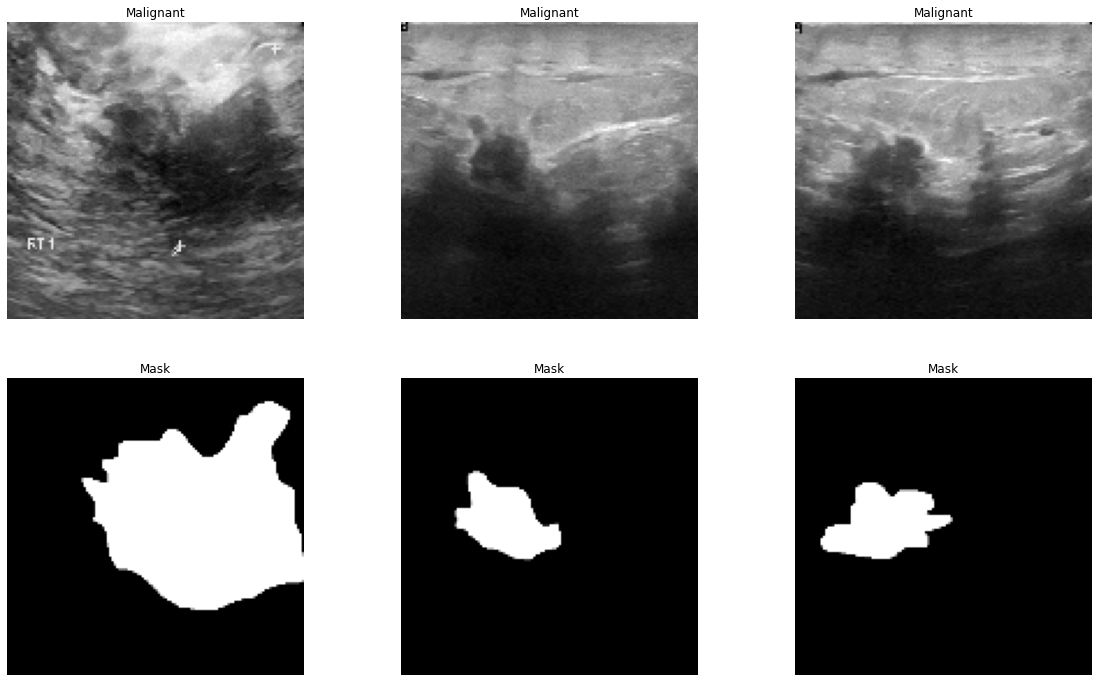

In [91]:
plt.figure(figsize = (20,12))

for i in range(3) :
    plt.subplot(2,3,i+1)
    plt.imshow(np.squeeze(x_malignant[i+1]), 'gray')
    plt.title('Malignant')
    plt.axis('off')

for i in range(3) :
    plt.subplot(2,3,i+4)
    plt.imshow(np.squeeze(y_malignant[i+1]), 'gray')
    plt.title('Mask')
    plt.axis('off')
plt.show()

# normal Images

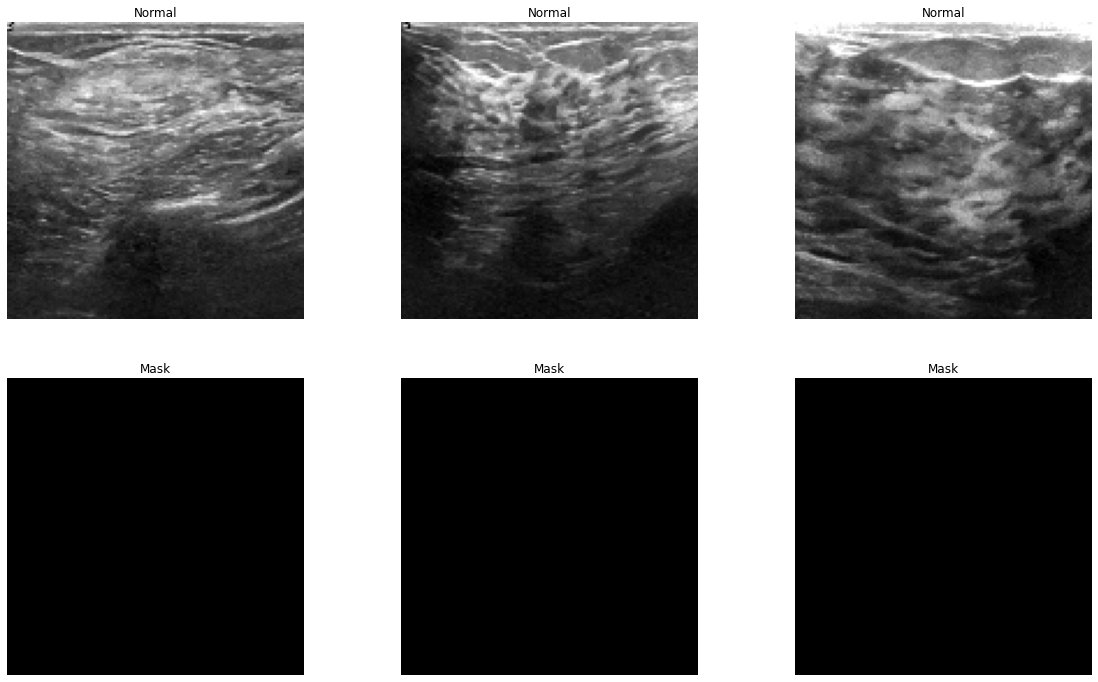

In [92]:
plt.figure(figsize = (20,12))

for i in range(3) :
    plt.subplot(2,3,i+1)
    plt.imshow(np.squeeze(x_normal[i+1]), 'gray')
    plt.title('Normal')
    plt.axis('off')

for i in range(3) :
    plt.subplot(2,3,i+4)
    plt.imshow(np.squeeze(y_normal[i+1]), 'gray')
    plt.title('Mask')
    plt.axis('off')
plt.show()

In [93]:
#collect all images 
images_seg = (np.concatenate((x_bengin, x_normal, x_malignant), axis = 0))/255
masks = (np.concatenate((y_bengin, y_normal, y_malignant), axis = 0))/255
print(images_seg.shape)
print(masks.shape)

(780, 128, 128, 1)
(780, 128, 128, 1)


# ploting Random Images

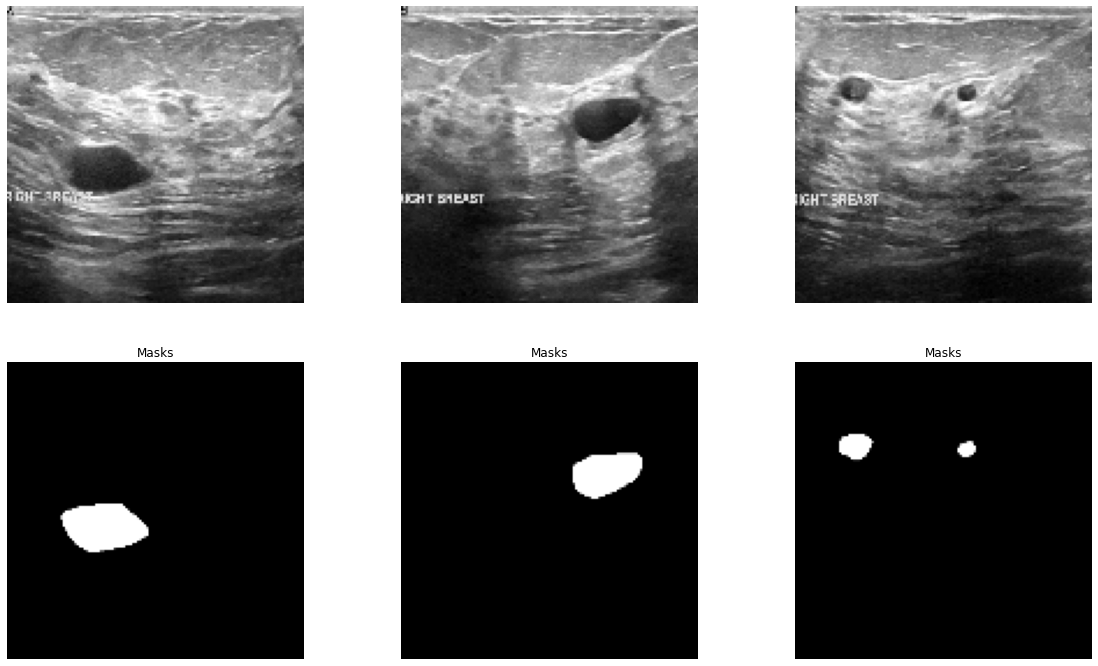

In [94]:
plt.figure(figsize = (20,12))

for i in range(3) :
    plt.subplot(2,3,i+1)
    plt.imshow(np.squeeze(images_seg[i+1]), 'gray')
    #plt.title('Benign')
    plt.axis('off')

for i in range(3) :
    plt.subplot(2,3,i+4)
    plt.imshow(np.squeeze(masks[i+1]), 'gray')
    plt.title('Masks')
    plt.axis('off')
plt.show()

In [95]:
image_height  = 128
image_width   = 128
image_channel = 1

In [96]:
y_pred_thresh = (y_pred>.5).astype(np.uint8)
y_pred_thresh

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1,

In [97]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np


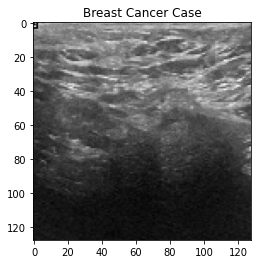

In [98]:
img = image.load_img("/kaggle/input/normal/normal (97).png",target_size=(128,128))

plt.imshow(img)
plt.title("Breast Cancer Case")
plt.show()
     

In [109]:
type(img)
img.size
img.format

In [99]:
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
pred = model.predict(img_batch)
print(pred)
pred_id = np.argmax(pred[0])
print(f'Probabilité : {round(pred[0][pred_id]*100, 2)} %')

if pred_id == 0:
    print("malignant")
elif pred_id == 1:
    print("normal")  
else:
    print("benign")


[[0.1873728  0.8107473  0.00187978]]
Probabilité : 81.07 %
normal


In [100]:
pred[0]

array([0.1873728 , 0.8107473 , 0.00187978], dtype=float32)

In [101]:
#start load image
                #2        #1          #0
classes = [ 'benign', 'normal','malignant']

In [102]:
model.save("model.h5")